# EE-411 Fundamentals of inference and learning, EPFL 
## Exercise Session 4: Regularized least-squares and gradient descent methods

In this fourth set of exercises,  we will discuss  how to solve least-squares problems with various techniques, and in particular the workhorse of modern machine learning: gradient descent. We shall first see how regularized least-square methods such as Ridge and LASSO perform on a simple statistical problem. Then, we will introduce different gradient descent methods and we use them on some simple surfaces, studying their performances. From the start, let's emphasize that doing gradient descent on a surface is different from performing gradient descent on a loss function in Machine Learning. The reason is that in ML not only do we want to find good minima, we want to find good minima that generalize well to new data. Despite this crucial difference, we can still build intuition about gradient descent methods by applying them to simple surfaces (see related blog posts [here](http://ruder.io/optimizing-gradient-descent/)).

**What you will learn today:** In this fourth notebook, you will have your first hands-on application on parametric methods in machine learning. We shall see how to use python to solve least-squared problems, and how to implement gradient descent for optimizing different functions. You will also gain intuition about various gradient descent methods by visualizing and applying these methods to some simple two-dimensional surfaces. Methods studied include ordinary gradient descent, gradient descent with momentum and NAG.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"] = (9, 9)
plt.rcParams["font.size"] = 16
np.random.seed(40)

Classification isn't the only task within the scope of supervised machine learning. **Regression** is another equally important task with many complementary features. In regression, we are asked to make a real-valued prediction based upon a dataset of samples. As in classification, we can think of our dataset as an $N\times P$ matrix, with $N$ samples and $P$ features, but now instead of binary *labels* corresponding to a partition of the dataset, we are interested in matching real-valued *response* variables. 

In the case of simple linear regression, the problems we look at are of the form
$$\mathbf{y} = \mathbf{X}\mathbf{w} + \mathbf{\xi},$$
where $\mathbf{y}$ are our response variables, the matrix $\mathbf{X}$ is our dataset and the vector $\mathbf{\xi}$ represents some noise or uncertainty on our model. Our hope is to find the *explanatory* variables $\mathbf{w}$ which are able to match our observations and which generalize to future observations.

Here, we will consider solving regressions via **maximum a posteriori (MAP)** approaches. From the Bayesian perspective, we are often attempting to solve the problem
$${\rm arg~min}_{\mathbf{w}} \; \big(-\log P(\mathbf{y}|X, \mathbf{w}) - \log P(\mathbf{w})\big).
$$ 

Now, if we return to our definition of linear regression, we assume that the additive noise is *iid* Gaussian and also a uniform prior on the value of $\mathbf{w}$, we arrive (as seen during the lecture) at the ordinary least squares (OLS) problem, namely

$$
{\rm arg~min}_{\mathbf{w}} \quad ||\mathbf{y} - X\mathbf{w} ||_2^2,
$$

which we can interpret as a **maximum likelihood (ML)** solution.

Regressions, and specifically linear regressions, often form the basis of the ___"Do The Simplest Thing That Could Possibly Work."___ Many times in production, simple regressions provide good-enough performance which maximizes the trade-off against engineering costs (coding time, computer time). And, as we will later see, regressions can even be applied to solve classification tasks, either directly or using instead *logistic* regression. So, truly, regressions should be one of the first step when encountering a new data-science or ML problem. Things can only, hopefully, go up from here!


# A) Optimization


## Ridge regression
First, we need to discuss the many ways to solve the minimization problem. We are going to assume that we are interested to the Ridge problem:
$$
\hat{\mathbf{w}} = {\rm arg~min}_{\mathbf{w}} \left( \frac 1n ||\mathbf{y} - X \mathbf{w} ||_2^2 + \lambda \|  \mathbf{w}\|_2^2 \right)$$ 
with $\mathbf{y} \in \mathbb R^n$,$\mathbf{w} \in \mathbb R^p$, and $X$ a $n \times p$ matrix. We have shown in the lecture that the solution should satify the normal equations:
$$
(X^T X + n \lambda {\mathbb 1}_p) \hat {\mathbf w} = X^T {\mathbf y}
$$
For any positive $\lambda$ the solution is unique (*question: why?*) and can be written either as (*question: why are these matrices invertible?*) 
$$
\hat {\mathbf w} = (X^T X + n\lambda {\mathbb 1}_p)^{-1} X^T {\mathbf y} = X^T (X X^T + n \lambda {\mathbb 1}_n)^{-1}  {\mathbf y}
$$

We shall see how to use these formulae. First we import the function `inv`, that allows us to invert matrices (indeed, if they are invertible)

In [ ]:
from scipy.linalg import inv
import time

Then we generate an artificial set of data for the problem, using `randn` to create an $n\times p$ matrix $X$ and a $n$-dimensional vector $y$, in both of which every element is generated randomly according to a Normal distribution of unitary variance.

In [ ]:
p = 3 #number of features
n = 30 #number of data points

X = np.random.randn(n,p)
y = np.random.randn(n,1)
lamb = 0.01

Compute the solution using the two methods:

In [ ]:
start = time.time()
w1 = inv(X.T@X+n*lamb*np.eye(p,p))@X.T@y
end = time.time()
print("formula 1 took :",end - start,"ms \n and the result is w1=",w1)

start2 = time.time()
w2 = X.T@inv(X@X.T+n*lamb*np.eye(n,n))@y
end2 = time.time()
print("formula 2 took :",end2 - start2,"ms \n and the result is w2=",w2)

formula 1 took : 0.0003867149353027344 ms 
 and the result is w1= [[-0.69842951]
 [ 0.23690601]
 [ 0.11037836]]
formula 2 took : 0.0051517486572265625 ms 
 and the result is w2= [[-0.69842951]
 [ 0.23690601]
 [ 0.11037836]]


#### 1) Which method seems to work faster? Repeat your experiment for different values of $n$ and $p$ to understand when it is better to use one or the other.

In [ ]:
#your code here

## Gradient Descent

An alternative to solve the problem is to use gradient descent! In order to keep number from exploding, we first define the cost function divided by the number of data as
$$
{\cal L}({\mathbf{w}}) = \frac {1}{2}  \bigg( \frac 1n ||\mathbf{y} - X \mathbf{w} ||_2^2 +  \lambda \|  \mathbf{w}\|_2^2 \bigg)$$


Therefore, the gradient reads
$$
\nabla_\mathbf{w} {\cal L}(\mathbf{w}) = -\frac 1n (X^T y - X^TX \mathbf {w}) + \lambda \mathbf {w} = \frac 1n (X^T (X {\mathbf w} - y)) + \lambda \mathbf {w}
$$



We import the function `norm`, which allows us to compute different matrix norms, and we choose some random initial weights

In [ ]:
from numpy.linalg import norm
w0 = np.random.rand(p,1) #Pick some random weights to start the algorithm

#### 2) Choose $n=30$ and $p=3$. Calling $\eta$ the step size and $t_{max}$ the number of iterations, design the function `gradient_descent` which, given $X$, $y$ and the parameters $\mathbf{w_0}$, $t_{max}$, $\lambda$ and $\eta$, returns the GD estimation for $w$ and the behaviour of the cost function ${\cal L}(\mathbf{w})$ with the different time steps.

In [ ]:
#your code here

#### 3) Fixing $t_{max}=50\,,$ for each value of $\eta$ in $[0.03,0.1,0.3,1,2,3]$
* Use the function you designed to plot the behaviour of the cost function vs the number of iterations
* Compute the distance between the final estimation of $\mathbf{w}$ and the exact one.

What do you observe?

In [ ]:
#your code here

## Ordinary Least Square and implicit regularization

Now, let's focus on the case where $n<p$ and let's compare the solution found by gradient descent when $\lambda=0$, with the one we find using just ordinary least squares:
$$
\hat{\mathbf{w}} = {\rm arg~min}_{\mathbf{w}} \quad ||\mathbf{y} - X \mathbf{w} ||_2^2 
$$ 


####  3) Try to use the formula

$$
\hat {\mathbf w} = (X^T X )^{-1} X^T {\mathbf y}
$$

#### to get the solution. What do you observe? Why this is happening?

Then, we can use the least norm solution:
$$
\hat {\mathbf w}_{ln} = X^T (X X^T)^{-1}  {\mathbf y}
$$

What do you observe? Why this is happening?

#### 4) Fix $p=100$ and $n=20$ and, taking $\lambda=0$, compare the solution obtained using $\hat{\mathbf w}_{ln}$ with 
* the one obtained by gradient descent with a random initilization
* the one obtained by gradient descent with a zero optimization

#### How can you explain the differences?

In [ ]:
#your code here

## LASSO and sub-gradient descent

Another cost function that shall be useful is the one corresponding to LASSO:
$$
{\cal L}({\mathbf{w}}) = \frac {1}{2n} ||\mathbf{y} - X \mathbf{w} ||_2^2 +  \lambda \|  \mathbf{w}\|_1 
$$

One can define the subgradient as
$$
\nabla_\mathbf{w} {\cal L}(\mathbf{w}) = -\frac 1n (X^T y - X^TX \mathbf {w}) + \lambda {\rm sign} ({\mathbf w}) = \frac 1n (X^T (X {\mathbf w}-y)) + \lambda {\rm sign}({\mathbf w})
$$


#### 5) Using  `np.sign()` to implement the sign function, construct the function `gradient_descent_lasso` that returns an estimation for $w$ and the behaviour of the cost function ${\cal L}(\mathbf{w})$ with the different time steps. Having done that, use this function to plot the cost function for a new dataset with  $p=100$ and $n=20$ .

In [ ]:
#your code here

## Bonus: LASSO with Iterartive soft Thresholding



In [ ]:
def my_soft_threshold(lamb, beta): #Soft Thresholding function
  return (beta>lamb)*(beta-lamb)+(beta<-lamb)*(beta+lamb)


def ISTA(X, y, w, iterations, l1, eta):
    past_costs = []
    for i in range(iterations):
        prediction =  X@w
        error = prediction - y
        argument = w - eta * X.T@error/n
        cost = (1/(2*n) * np.dot(error.T, error) + 1/(2.0) * l1 * np.linalg.norm((w), ord=1))[0,0]        
        past_costs.append(cost)
        w = my_soft_threshold(l1*eta,argument)
    return w, past_costs

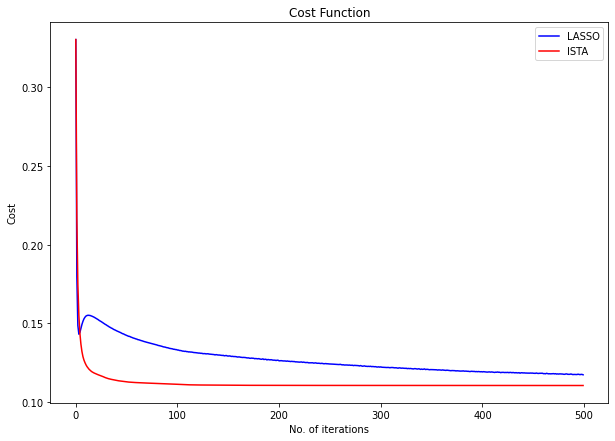

In [ ]:
fig = plt.figure(figsize=(10,7))
w, past_costs = gradient_descent_lasso(X, y, w0, max, lamb, eta)
w2, past_costs2 = ISTA(X, y, w0, max, lamb, eta)
plt.title('Cost Function')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(past_costs,'-b', label='LASSO')
plt.plot(past_costs2,'-r', label='ISTA')
plt.legend()
plt.show()

# B) Surfaces

We will consider two simple surfaces: A quadratic minimum of the form 

$$
z=ax^2+by^2\,,
$$

and the [Matyas function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), a convex function often used to test optimization problems of the form:

$$
z(x,y) = 0.26(x^2 + y^2) - 0.48xy
$$


These surfaces can be plotted using the code below: 

In [ ]:
#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

#Function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap, 'linewidth': 20, 'antialiased': True, 'vmin': -2, 'vmax': 2} #parameters for the plots
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev) #point of view
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

#Overlay the trajectory of GD on a contour plot

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

We now define the functions for the Matyas function and the respective gradient, that we will need for the algorithms:

In [ ]:
# Define matyas_surface and the respective gradient

def matyas_surface(x,y):
    return 0.26*(x**2 + y**2) - 0.48*x*y

def grad_matyas_surface(params):
    x=params[0]
    y=params[1]
    grad_x= 0.52*x-0.48*y
    grad_y= 0.52*y-0.48*x
    return [grad_x,grad_y]


6) Now do the  same for the quadratic minimum surface

In [ ]:
#your code here

First of all, we can plot these surfaces to see how they look like (choose for example $a=1.5$ and $b=2$ for the saddle point)

In [ ]:
#Make plots of the surfaces

plt.close() # closes previous plots
x, y = np.mgrid[-1:1:31j, -1:1:31j] #31 points between -1 and 1
fig1,ax1=plot_surface(x,y,matyas_surface(x,y))
plt.show()

#your code (add the other one)

## Gradient descent with and without momentum

Now, let's visualize various gradient descent algorithms used in machine learning. We will be especially interested in trying to understand how various hyperparameters, especially the learning rate, affect our performance.

As always, we will work with some parameters $\mathbf{w}$ and we have an energy function we are trying to minimize, usually denoted by ${\cal L}(\mathbf{w})$.

<b>Gradient Descent</b>

We start by considering a simple gradient descent method. In this method,
we will take steps in the direction of the local gradient. Given some parameters $\mathbf{w}$, we adjust them at each iteration so that

$$\mathbf{w}_{t+1}= \mathbf{w}_t - \eta_t \nabla_\mathbf{w} {\cal L}(\mathbf{w}),$$

where we have introduced the learning rate $\eta_t$ that controls how large a step we take. In general, the algorithm is extremely sensitive to the choice of $\eta_t$. If $\eta_t$ is too large, then one can wildly oscillate around minima and miss important structure at small scales. This problem is amplified if our gradient computations are noisy and inexact (as is often the case in machine learning applications). If $\eta_t$ is too small, then the learning/minimization procedure becomes extremely slow. This raises the natural question: <i> What sets the natural scale for the learning rate and how can we adaptively choose it?</i>

<b>Gradient Descent with Momentum</b>
One problem with gradient descent is that it has no memory of where the "ball rolling down the hill" comes from. This can be an issue when there are many shallow minima in our landscape. If we make an analogy with a ball rolling down a hill, the lack of memory is equivalent to having no inertia or momentum (i.e. completely overdamped dynamics). Without momentum, the ball has no kinetic energy and cannot climb out of shallow minima. 

Momentum becomes especially important when we start thinking about **stochastic gradient descent** with noisy, stochastic estimates of the gradient. In this case, we should remember where we were coming from and not react drastically to each new update.



Inspired by this, we can add a memory or momentum term to the stochastic gradient descent term above:

$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\mathbf{w} {\cal L}(\mathbf{w}_t),\\
\mathbf{w}_{t+1}= \mathbf{w}_t -v_{t},
$$

with $0\le \gamma < 1$ called the momentum parameter. When $\gamma=0$, this reduces to ordinary gradient descent, and increasing $\gamma$ increases the inertial contribution to the gradient. From the equations above, we can see that typical memory lifetimes of the gradient is given by $(1-\gamma)^{-1}$. For $\gamma=0$ as in gradient descent, the lifetime is just one step. For $\gamma=0.9$, we typically remember a gradient for ten steps. We will call this gradient descent with **classical momentum** or CM for short.

**NAG** A final widely used variant of gradient descent with momentum is called the Nesterov accelerated gradient (NAG). In NAG, rather than calculating the gradient at the current position, one calculates the gradient at the position momentum will carry us to at time $t+1$, namely, $\mathbf{w}_t -\gamma v_{t-1}$. Thus, the update becomes
$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\mathbf{w} {\cal L}(\mathbf{w}_t-\gamma v_{t-1})\\
\mathbf{w}_{t+1}= \mathbf{w}_t -v_{t}
$$

Let's now write the functions to implement these different versions of gradient descent, starting with standard GD

In [ ]:
#Simple gradient descent

def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

7) Now write yourself the functions implementing GD with CM and NAG

In [ ]:
#your code here

## Experiments with GD, CM, and NAG

Let us play with these methods to gain some intuition.

Let's look at the dependence of GD on learning rate in the Matyas surface. We do the plot below for $\eta=0.1, 0.5, 1, 2$.
<ul>
<li>
What are the qualitatively different behaviors that arise as $\eta$ is increased?
<li> What does this tell us about the importance of choosing learning parameters? 
</ul>


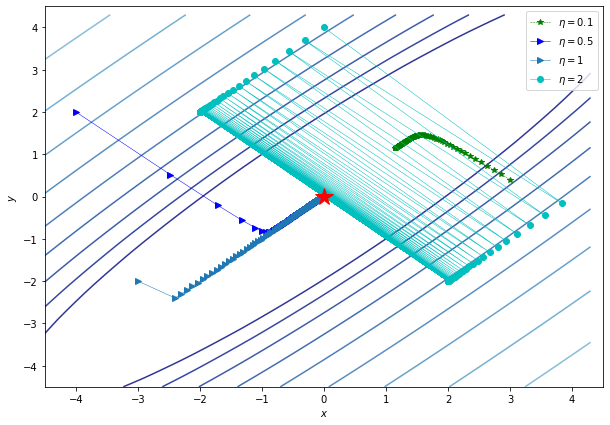

In [ ]:
# Investigate effect of learning rate in GD
plt.close()
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
z=np.abs(matyas_surface(x,y))

#initial point
init4=[0,4]
init2=[-4,2]
init3=[-3,-2]
init1=[3,0.4]
eta1=0.1
eta2=0.5
eta3=1
eta4=2

ax1.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax1.set_xlim((-4.5, 4.5))
ax1.set_ylim((-4.5, 4.5))

gd_1=gd(grad_matyas_surface,init1, n_epochs=100, eta=eta1)
gd_2=gd(grad_matyas_surface,init2, n_epochs=100, eta=eta2)
gd_3=gd(grad_matyas_surface,init3, n_epochs=100, eta=eta3)
gd_4=gd(grad_matyas_surface,init4, n_epochs=100, eta=eta4)

overlay_trajectory_contour(ax1,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax1,gd_2,'$\eta=$%s'% eta2,'b->', lw=0.5)
overlay_trajectory_contour(ax1,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax1,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)

ax1.plot(0,0, 'r*', markersize=18)

plt.legend()
plt.show()

8) Do the same for the quadratic minimum. How do these change if we change $a$ and $b$ above? In particular how does anisotropy change the learning behavior?

In [ ]:
#your code here

9) Make similar plots for CM and NAG. How do the learning rates for these procedures compare with those for GD?

In [ ]:
#your code here